<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/utterance_generation/Basic%20Utterance%20Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 19 15:54 .
drwxr-xr-x 4 root root 4.0K Jun 19 15:54 ..
-rw-r--r-- 1 root root 5.6M Jun 19 15:54 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 19 15:54 original
-rw-r--r-- 1 root root  49M Jun 19 15:54 test.tsv
-rw-r--r-- 1 root root  50M Jun 19 15:54 train.tsv


In [58]:
import os
import time
import math
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [6]:
len(train_df), len(valid_df)

(363192, 40372)

Text(0.5, 0, 'Train data distribution')

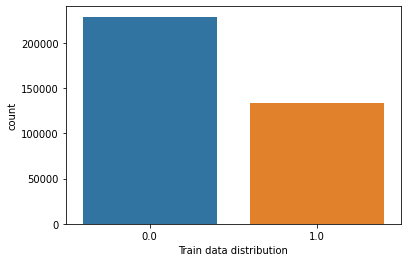

In [7]:
sns.countplot(train_df['is_duplicate'])
plt.xlabel('Train data distribution')

Text(0.5, 0, 'Valid data distribution')

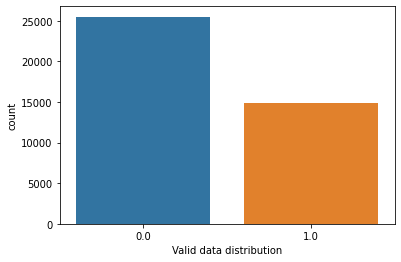

In [8]:
sns.countplot(valid_df['is_duplicate'])
plt.xlabel('Valid data distribution')

In [9]:
train_data = train_df[train_df['is_duplicate'] == 1]
valid_data = valid_df[valid_df['is_duplicate'] == 1]

In [10]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
7,106969,147570,787.0,What is the best self help book you have read?...,What are the top self help books I should read?,1.0
11,233239,71243,177376.0,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...,1.0
13,11568,22332,22333.0,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?,1.0


In [11]:
len(train_data), len(valid_data)

(134141, 14857)

In [12]:
train_data = train_data[['question1', 'question2']]
valid_data = valid_data[['question1', 'question2']]

In [13]:
train_data.head()

,question1,question2
1,How do I control my horny emotions?,How do you control your horniness?
3,What can one do after MBBS?,What do i do after my MBBS ?
7,What is the best self help book you have read?...,What are the top self help books I should read?
11,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...
13,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?


In [59]:
sample_train_data = train_data.sample(50000)
sample_valid_data = valid_data.sample(5000)

In [60]:
sample_train_data.to_csv('train_ds.csv')
sample_valid_data.to_csv('valid_ds.csv')

In [61]:
!ls -lah

total 97M
drwxr-xr-x 1 root root 4.0K Jun 19 16:14 .
drwxr-xr-x 1 root root 4.0K Jun 19 15:44 ..
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 .config
drwxr-xr-x 4 root root 4.0K Jun 19 15:54 glue_data
-rw-r--r-- 1 root root  91M Jun 19 16:14 model.pt
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root 5.5M Jun 19 16:14 train_ds.csv
-rw-r--r-- 1 root root 559K Jun 19 16:14 valid_ds.csv


In [62]:
tokenizer = data.get_tokenizer('spacy')
TEXT = data.Field(tokenize=tokenizer, lower=True, init_token='<sos>', eos_token='<eos>')

In [63]:
fields = [(None, None), ("source", TEXT), ("target", TEXT)]

train_dataset, valid_dataset = data.TabularDataset.splits(path='.',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=fields)

In [64]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")

Number of training examples: 50000
Number of validation examples: 5000


In [65]:
print(vars(train_dataset.examples[1]))

{'source': ['if', 'hillary', 'clinton', 'wins', 'the', 'presidency', ',', 'can', 'she', 'pardon', 'herself', 'for', 'previous', 'wrong', 'doings', '?'], 'target': ['if', 'hillary', 'clinton', 'is', 'president', ',', 'and', 'the', 'fbi', 'is', 'investigating', 'her', ',', 'can', 'she', 'influence', 'the', 'fbi', 'and/or', 'give', 'herself', 'a', 'presidential', 'pardon', '?']}


In [66]:
TEXT.build_vocab(train_dataset, min_freq=5)

In [67]:
print(f"Number of tokens in vocabulary: {len(TEXT.vocab)}")

Number of tokens in vocabulary: 8142


In [68]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.source),
    device=device
)

In [69]:
# sample checking
temp = next(iter(train_iterator))
temp.source.shape, temp.target.shape

(torch.Size([29, 64]), torch.Size([27, 64]))

In [70]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, bidirectional=True, num_layers=n_layers, dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # src => [seq_len, batch_size]

        embedded = self.dropout(self.embedding(src))
        # embedded => [seq_len, batch_size, hidden_dim]

        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs => [seq_len, batch_size, hidden_dim * 2]
        # hidden, cell => [num_layers * num_dir, batch_size, hidden_dim]

        hidden = hidden.view(self.n_layers, 2,  -1, self.hidden_dim)
        cell = cell.view(self.n_layers, 2,  -1, self.hidden_dim)
        # hidden, cell => [num_layers, num_dir, batch_size, hidden_dim]

        final_forward_hidden = hidden[:, 0, :, :]
        final_backward_hidden = hidden[:, 1, :, :]
        # final_hiddens => [num_layers, batch_size, hidden_dim]

        final_forward_cell = cell[:, 0, :, :]
        final_backward_cell = cell[:, 1, :, :]
        # final_cells => [num_layers, batch_size, hidden_dim]

        combined_hidden = torch.cat((final_forward_hidden, final_backward_hidden), dim=2)
        combined_cell = torch.cat((final_forward_cell, final_backward_cell), dim=2)
        # combined_hidden, combined_cell => [num_layers, batch_size, hidden_dim * 2]

        decoder_initial_hidden = self.fc(combined_hidden)
        decoder_initial_cell = self.fc(combined_cell)
        # decoder_initial_states => [num_layers, batch_size, hidden_dim]

        return decoder_initial_hidden, decoder_initial_cell

In [71]:
class Decoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, cell):
        # input => [seq_len, batch_size, emb_dim]
        #       => [1, batch_size, emb_dim]
        # hidden => [num_layers, batch_size, hidden_dim]
        # cell => [num_layers, batch_size, hidden_dim]

        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output => [1, batch_size, hidden_dim]
        # hidden => [num_layers, batch_size, hidden_dim]
        # cell => [num_layers, batch_size, hidden_dim]

        logits = self.fc(self.dropout(output.squeeze(0)))
        # logits => [batch_size, output_dim]

        return logits, hidden, cell


In [72]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src => [seq_len, batch_size]
        # trg => [trg_len, batch_size]

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.input_dim

        # outputs: to store the predictions of the decoder
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        # hidden, cell => [num_layers, batch_size, hidden_dim]

        dec_inp = trg[0, :]

        for t in range(1, trg_len):
            dec_inp_emb = self.encoder.embedding(dec_inp.unsqueeze(0))
            # dec_inp_emb => [1, batch_size, emb_dim]
            output, hidden, cell = self.decoder(dec_inp_emb, hidden, cell)

            # save the output
            outputs[t] = output

            # to decide whether to use teacher force or not
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            dec_inp = trg[t] if teacher_force else top1
        
        return outputs


In [73]:
INPUT_DIM = len(TEXT.vocab)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
dec = Decoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

In [74]:
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8142, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=8142, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 19917774 trainable parameters


In [76]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [77]:
def train(model, iterator, criterion, optimizer, clip):
    epoch_loss = 0

    # keep the model in train mode
    model.train()

    # iterate over train data
    for i, batch in enumerate(iterator):
        src = batch.source
        trg = batch.target
        # src => [seq_len, batch_size]
        # trg => [seq_len, batch_size]

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(src, trg)

        # reshaping the output to make it compatible to cal. loss
        # can also do without reshaping
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        # backward pass
        loss.backward()

        # gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # update the parameters of the model
        optimizer.step()

        # update the loss
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [78]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    
    # keep the model in eval mode
    model.eval()
    
    # do not calculate gradients
    with torch.no_grad():

        # iterate over the data
        for batch in iterator:
            src = batch.source
            trg = batch.target
            # src => [seq_len, batch_size]
            # trg => [seq_len, batch_size]

            # forward pass
            # make sure the teacher_forcing_ratio is 0 in eval
            output = model(src, trg, 0)

            # reshaping for loss calculation
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # loss
            loss = criterion(output, trg)

            # update loss
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [79]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [80]:

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f"Epoch {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} |")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f} |")

Epoch 1 | Time: 3m 50.459569692611694s
	Train Loss: 4.880 | Train PPL: 131.647 |
	Valid Loss: 4.678 | Valid PPL: 107.600 |
Epoch 2 | Time: 3m 50.4044885635376s
	Train Loss: 4.148 | Train PPL:  63.304 |
	Valid Loss: 4.338 | Valid PPL:  76.536 |
Epoch 3 | Time: 3m 50.281089544296265s
	Train Loss: 3.800 | Train PPL:  44.720 |
	Valid Loss: 4.143 | Valid PPL:  62.983 |
Epoch 4 | Time: 3m 49.98819971084595s
	Train Loss: 3.555 | Train PPL:  34.998 |
	Valid Loss: 4.039 | Valid PPL:  56.754 |
Epoch 5 | Time: 3m 50.10717558860779s
	Train Loss: 3.373 | Train PPL:  29.173 |
	Valid Loss: 3.907 | Valid PPL:  49.751 |
Epoch 6 | Time: 3m 51.846423625946045s
	Train Loss: 3.232 | Train PPL:  25.321 |
	Valid Loss: 3.859 | Valid PPL:  47.411 |
Epoch 7 | Time: 3m 51.39446544647217s
	Train Loss: 3.102 | Train PPL:  22.249 |
	Valid Loss: 3.781 | Valid PPL:  43.841 |
Epoch 8 | Time: 3m 51.10394048690796s
	Train Loss: 3.018 | Train PPL:  20.458 |
	Valid Loss: 3.723 | Valid PPL:  41.373 |
Epoch 9 | Time: 3m 51.